Each models is required to generate a stack ranking of all properties listed for sale in the database.

This script runs daily, reads in CSV files with a sorted order of homes (most attractive at the top to least attractive at the bottom), and a 'ypred' variable that reflects the scripts absolute metric (like P&L or probability of sale).

The script compares each list with homes that were sold, and identifies closed transactions ('positives') as well as the top 10 properties that each model identified that didn't sell ('negatives'). The remainder is considered 'control set'. 

For the overall data set, and specifically for each of those 3 groups, we output the average 'ypred' value, what number and percentage of homes sold from each.

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import os
from slacker import Slacker
import json
import requests
from cloudinary.uploader import upload
from cloudinary.utils import cloudinary_url
from cloudinary.api import delete_resources_by_tag, resources_by_tag

csv_path = '/home/ilya/Code/rentalnerd/scraper/'
today = dt.date.today()


%matplotlib inline
        
# slack secrets (in your ~/.bashrc)
webhook_url = os.environ.get('SLACK_URL')
slacker = Slacker(os.environ.get('SLACK_TOKEN'))

# how old a target list to compare to the current target list
lag_days = 40

pd.set_option('display.max_colwidth', -1)
discount = 0.050

# to remove all the random far away areas - PHX only
zipcode_list = ['85006', '85007', '85008', '85009', '85013', '85015', '85016', '85017',
       '85018', '85019', '85020', '85021', '85022', '85023', '85024',
       '85027', '85028', '85029', '85031', '85033', '85035', '85037',
       '85040', '85041', '85043', '85044', '85048', '85050', '85051',
       '85053', '85085', '85086', '85087', '85118', '85138', '85139',
       '85142', '85143', '85202', '85203', '85204', '85205', '85206',
       '85207', '85209', '85210', '85212', '85213', '85215', '85224',
       '85225', '85226', '85233', '85234', '85248', '85249', '85250',
       '85251', '85253', '85254', '85255', '85257', '85258', '85262',
       '85266', '85286', '85295', '85296', '85297', '85298', '85301',
       '85302', '85303', '85304', '85305', '85306', '85308', '85310',
       '85323', '85326', '85331', '85335', '85339', '85340', '85351',
       '85353', '85355', '85373', '85374', '85375', '85382', '85383',
       '85388', '85390', '85392', '85396', '85704', '85705', '85706',
       '85711', '85712']

In [2]:
def plot_rounds(plot):
    # uploads the graph to the web and returns the URL
    
    fig = plot.get_figure()
    fig.tight_layout()
    fig.savefig('temp_plot.png')
    
    response = upload("temp_plot.png")
    url, options = cloudinary_url(response['public_id'],
        format = response['format'],
        crop = "fill")
    return url

In [3]:
def slack(text, url = None, title = None):
    print("Slacking: " + text)
    
    if url == None:
        data=json.dumps({"text": text})
    else:
        data = json.dumps( { "text": text, "attachments": [ { "fallback": "Model MAE"
                                           , "title": title
                                           , "image_url": url } ] } )
    
    response = requests.post(webhook_url, data , headers={'Content-Type': 'application/json'})
    if response.status_code != 200:
        raise ValueError('Request to slack returned an error %s, the response is:\n%s' % (response.status_code, response.text))


In [4]:
closed = pd.read_csv('CSV_backups/ALL-sales.csv',nrows=10000000, index_col=['property_id','transaction_id'])

/home/ilya/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (13,14,15,17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
closed.head()

,,price,transaction_status,date_listed,date_closed,days_on_market,transaction_type,is_latest,price_listed,price_closed,date_transacted_latest,...,school_district_id_57.0,school_district_id_60.0,school_district_id_67.0,school_district_id_68.0,school_district_id_75.0,school_district_id_87.0,school_district_id_90.0,school_district_id_93.0,school_district_id_96.0,school_district_id_nan
property_id,transaction_id,,,,,,,,,,,,,,,,,,,,,
220941,23845986,315000,closed,NaN,6529,NaN,sales,False,NaN,315000,2017-11-16,...,0,0,0,0,0,0,0,0,0,0
8975845,23845958,111500,closed,NaN,6316,NaN,sales,False,NaN,111500,2017-04-17,...,0,0,0,0,0,0,0,0,0,0
20915,23845890,400000,closed,NaN,6528,NaN,sales,False,NaN,400000,2017-11-15,...,0,0,0,0,0,0,0,0,0,0
9020094,23845861,199000,closed,NaN,6529,NaN,sales,False,NaN,199000,2017-11-16,...,0,0,0,0,0,0,0,0,0,0
167914,23845832,304900,closed,NaN,6501,NaN,sales,False,NaN,304900,2017-10-19,...,0,0,0,0,0,0,0,0,0,0


In [6]:
# read in prior target list for backtesting purposes
model_results = np.empty([0,7])
for lag_days in range(1,2):
    print("Lag days %i\n\n" % lag_days)
    try:
        prior_target_list = pd.read_csv(csv_path + 'good_sell/gs_target_list_' + (today-dt.timedelta(days=lag_days)) \
                                    .strftime('%Y%m%d') + '.csv', index_col = [0,1]) \
                                    .rename(columns = { 'ypred' : 'good_sell_prob'})

        backtest = prior_target_list.join(closed[['price']], how="inner").sort_values(by='good_sell_prob',ascending=False)
        backtest['good_sell'] = (backtest.price >= (backtest.list * (1-discount)))
        y_all = prior_target_list.good_sell_prob.mean()
        y_sold = backtest.good_sell_prob.mean()

        pos_trigger = prior_target_list.good_sell_prob.quantile(0.75)
        slack("Prior target list length: %i\tNum sold: %i\tAvg good sell prob: %f\tAvg good sell prob of sold: %f" 
              % (len(prior_target_list.index), len(backtest.index),y_all, y_sold))

        num_pos = len(prior_target_list[prior_target_list.good_sell_prob > pos_trigger].index)
        positives = backtest[backtest.good_sell_prob > pos_trigger]
        y_pos = (-(positives.price - positives.list) / positives.list).median()
        num_sold = len(positives.index)
        if num_sold == 0:
            slack("Num of homes with good_sell_prob > %f: %i\tPerc of those sold: NONE\tMed disc to list: NA" % (pos_trigger, num_pos) )    
        else:
            slack("Num of homes with good_sell_prob > %f: %i\tPerc of those sold: %f\tMed disc to list: %f" 
                  % (pos_trigger, num_pos, num_sold / num_pos *  100, y_pos * 100))

        neg_trigger = prior_target_list.good_sell_prob.quantile(0.25)
        num_neg = len(prior_target_list[prior_target_list.good_sell_prob < neg_trigger].index)
        negatives = backtest[backtest.good_sell_prob < neg_trigger]
        y_neg = (-(negatives.price - negatives.list) / negatives.list).median()
        num_sold = len(negatives.index)

        if num_sold == 0:
            slack("Num of homes with good_sell_prob < %f: %i\tPerc of those sold: NONE\tMedian disc to list: NA" % (neg_trigger, num_neg))
        else:
            slack("Num of homes with good_sell_prob < %f: %i\tPerc of those sold: %f\tMedian disc to list:%f" 
                  % (neg_trigger, num_neg, len(negatives.index) / num_neg * 100, y_neg * 100))

        slack(backtest.to_string())
        backtest.to_csv("median_check.csv")
        # store results in arrays for graphing
        r = np.array([[lag_days, len(prior_target_list.index), len(backtest.index), num_sold / num_pos * 100, y_pos * 100, len(negatives.index) / num_neg * 100, y_neg * 100]])
        model_results = np.append(model_results,r,axis=0)
        
    except Exception as err:   
        print(err)

Lag days 1


Slacking: Prior target list length: 1295	Num sold: 0	Avg good sell prob: 0.535053	Avg good sell prob of sold: nan
Slacking: Num of homes with good_sell_prob > 0.635244: 324	Perc of those sold: NONE	Med disc to list: NA
Slacking: Num of homes with good_sell_prob < 0.505569: 324	Perc of those sold: NONE	Median disc to list: NA
Slacking: Empty DataFrame
Columns: [address, zipcode, good_sell_prob, list, url, lat, long, date_listed, transaction_date, price, good_sell]
Index: []


In [7]:
import matplotlib.pyplot as plt
index = pd.Index(model_results[:,0], names='lag_days')
graph_results = pd.DataFrame(model_results[:,1:],index=index,columns=['num_for_sale', 'num_sold', 'perc_sold_good','discount_good', 'perc_sold_bad', 'discount_bad']) \
                    .sort_index(ascending=False)

graph_results.head()

,num_for_sale,num_sold,perc_sold_good,discount_good,perc_sold_bad,discount_bad
1.0,1295.0,0.0,0.0,NaN,0.0,NaN


In [8]:
# graph_results[['num_for_sale', 'discount_good','discount_bad']].plot(figsize=(14,14),secondary_y='num_for_sale')

In [9]:
# read in prior target list for backtesting purposes
prior_target_list = pd.read_csv(csv_path + 'value_buy/vb_target_list_' + (today-dt.timedelta(days=lag_days)) \
                                .strftime('%Y%m%d') + '.csv', index_col = [0,1]) \
                                .rename(columns = { 'ypred' : 'pnl'})

try:
    backtest = prior_target_list.join(closed['price'], how="inner").sort_values(by='pnl',ascending=False)
    backtest['good_sell'] = (backtest.price >= (backtest.list * (1-discount)))
    avg_pnl = backtest.pnl.mean()
    predicted_price = backtest.predicted_price.mean()
    sale_price = backtest.price.mean()

    slack("Prior target list length: %i\tNum sold: %i\tAvg P&L: %f\tAvg predict price: %f\tAvg sale price: %f" 
          % (len(prior_target_list.index), len(backtest.index),y_all, predicted_price, sale_price))

    pos_trigger = prior_target_list.pnl.quantile(0.75)
    num_pos = len(prior_target_list[prior_target_list.pnl > pos_trigger].index)
    positives = backtest[backtest.pnl > pos_trigger]
    y_pos = (-(positives.price - positives.list) / positives.list).mean()
    num_sold = len(positives.index)
    if num_sold == 0:
        slack("Num of homes with pnl > %f: %i\tPerc of those sold: NONE\tAvg disc to list: NA" % (pos_trigger, num_pos) )    
    else:
        slack("Num of homes with pnl > %f: %i\tPerc of those sold: %f\tAvg disc to list: %f" 
              % (pos_trigger, num_pos, num_sold / num_pos, y_pos))

    neg_trigger = prior_target_list.pnl.quantile(0.25)

    num_neg = len(prior_target_list[prior_target_list.pnl < neg_trigger].index)
    negatives = backtest[backtest.pnl < neg_trigger]
    y_neg = (-(negatives.price - negatives.list) / negatives.list).mean()
    num_sold = len(negatives.index)

    if num_sold == 0:
        slack("Num of homes with pnl < %f: %i\tPerc of those sold: NONE\tAvg disc to list: NA" % (neg_trigger, num_neg))
    else:
        slack("Num of homes with pnl < %f: %i\tPerc of those sold: %f\tAvg disc to list:%f" 
              % (neg_trigger, num_neg, len(negatives.index) / num_neg, y_neg))

    slack(backtest.to_string())
except Exception as err:   
    slack("No homes sold since last run")

Slacking: Prior target list length: 2365	Num sold: 0	Avg P&L: 0.535053	Avg predict price: nan	Avg sale price: nan
Slacking: Num of homes with pnl > -118499.117188: 591	Perc of those sold: NONE	Avg disc to list: NA
Slacking: Num of homes with pnl < -177160.953125: 591	Perc of those sold: NONE	Avg disc to list: NA
Slacking: Empty DataFrame
Columns: [address, zipcode, pnl, predicted_price, list, url, price, good_sell]
Index: []


In [10]:
vb = pd.read_csv('value_buy/vb_target_list_' + today.strftime('%Y%m%d') + '.csv', index_col = ['property_id','transaction_id']) \
       .drop(['address','zipcode', 'url','list'],axis=1) \
       .rename(columns = { 'ypred': 'pnl'}) \
       .drop_duplicates()
    
gs = pd.read_csv('good_sell/gs_target_list_'  + today.strftime('%Y%m%d') + '.csv', index_col = ['property_id','transaction_id'])  \
       .rename(columns = { 'ypred' : 'good_sell_prob'}) \
       .drop_duplicates()
        
vb = vb[~vb.index.duplicated(keep='first')]
gs = gs[~gs.index.duplicated(keep='first')]
    
print("Len of value buy\t%i" % len(vb.index))
print("Len of good sell\t%i" % len(gs.index))

c = pd.concat([vb,gs],axis=1, join='inner')

c['pnl_percent'] = (c.pnl / c.list)

c = c[(c.list < 250000) & (c.list > 100000)  \
      & (~c.address.str.contains("Rent|rent|LOT|#|Sun City"))] 

Len of value buy	2445
Len of good sell	1340


/home/ilya/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Slacking: 


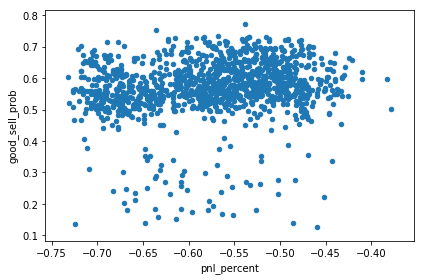

In [11]:
url = plot_rounds(c.query('good_sell_prob > 0.00').plot.scatter(x='pnl_percent', y='good_sell_prob'))
slack("", url, "Model Correlation")

In [12]:
# ran both data datasets and combine to create an equally weighted ensemble ranking
c["pnl_rank"] = c.pnl.rank(ascending=False)
c["gs_rank"] = c.good_sell_prob.rank(ascending=False)
c["rank"] = (c.pnl_rank + c.gs_rank)
c["zipcode"] = c.zipcode.apply(str)

# filter the output to remove duds
d = c[(c.pnl_percent > -0.2) & (c.good_sell_prob > 0.4) & (c.zipcode.isin(zipcode_list))]

In [13]:
d = c.sort_values("rank").nsmallest(20, "gs_rank")

file = csv_path + 'ensemble/comb_target_list_' + today.strftime('%Y%m%d') + '.csv'
np.round(d[['address', 'zipcode','list','predicted_price','pnl_percent','good_sell_prob','rank','url']], 4).to_csv(file)

slacker.files.upload(file, channels='#progress')

In [14]:
for_sale = pd.read_csv('CSV_backups/ALL-for_sale.csv', index_col=['property_id','transaction_id'])
for_sale['zipcode'] = for_sale.zipcode.apply(str)

In [15]:
from math import radians, cos, sin, asin, sqrt
def haversine(row, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    lon1 = row.longitude
    lat1 = row.latitude
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    km = 6367 * c
    return km / 1.60934 # convert to miles

In [16]:
for r, target in d.iterrows():
    print(target.name[0])
    print(target.address)
    target.longitude = for_sale.loc[target.name].longitude
    target.latitude = for_sale.loc[target.name].latitude
    
    # get all properties listed for sale in the same zipcode as our target
    z = for_sale[(for_sale.zipcode == target.zipcode)]
    print(len(z.longitude))
    
    z['dist'] = z.apply(haversine, lon2 = target.longitude, lat2 = target.latitude, axis=1)
    print(z[['address','dist']].nsmallest(5,'dist'))
    

43124
7301 W Payson Rd, Phoenix, AZ 85043 
23
                                                          address      dist
property_id transaction_id                                                 
43124       23755414        7301 W Payson Rd, Phoenix, AZ 85043    0.000000
40212       23823118        2916 S 72nd Ln, Phoenix, AZ 85043      0.048335
40221       23817839        2920 S 72nd Ln, Phoenix, AZ 85043      0.055240
42777       23846103        7112 W Watkins St, Phoenix, AZ 85043   0.354485
352598      23759699        7130 W Whyman Ave, Phoenix, AZ 85043   0.417277
1131996
982 N Los Altos Dr, Chandler, AZ 85224 
69
                                                            address      dist
property_id transaction_id                                                   
1131996     23755340        982 N Los Altos Dr, Chandler, AZ 85224   0.000000
1121780     23784042        2386 W Shannon St, Chandler, AZ 85224    0.125113
1121709     23844441        2370 W Orchid Ln, Chandler, AZ 

/home/ilya/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



15 N 86th Ln, Tolleson, AZ 85353 
19
                                                             address      dist
property_id transaction_id                                                    
359160      23759845        15 N 86th Ln, Tolleson, AZ 85353          0.000000
9012601     23824429        8709 W C P Hayes Dr, Tolleson, AZ 85353   0.403483
9019605     22737585        9213 W Fillmore St, Tolleson, AZ 85353    0.763734
8991893     23837557        9352 W Jefferson St, Tolleson, AZ 85353   0.876303
364303      22743539        9353 W Taylor St, Tolleson, AZ 85353      0.905179
1413516
7311 N 73rd Dr, Glendale, AZ 85303 
38
                                                             address      dist
property_id transaction_id                                                    
1413516     22924606        7311 N 73rd Dr, Glendale, AZ 85303        0.000000
1412890     23823749        7253 W Aurelius Ave, Glendale, AZ 85303   0.213261
1410517     21990149        7108 N 73rd Dr, Gl

In [17]:
d

,,pnl,predicted_price,address,zipcode,good_sell_prob,list,url,lat,long,date_listed,transaction_date,pnl_percent,pnl_rank,gs_rank,rank
property_id,transaction_id,,,,,,,,,,,,,,,
43124,23755414,-104956.734375,90043.265625,"7301 W Payson Rd, Phoenix, AZ 85043",85043,0.772899,195000,https://www.zillow.com/homedetails/7301-W-Payson-Rd-Phoenix-AZ-85043/60975135_zpid/,33.4225,-112.217,2017-10-18,2017-10-18,-0.538240,178.0,1.0,179.0
1131996,23755340,-124020.929688,70979.070312,"982 N Los Altos Dr, Chandler, AZ 85224",85224,0.751952,195000,https://www.zillow.com/homedetails/982-N-Los-Altos-Dr-Chandler-AZ-85224/8184826_zpid/,33.3198,-111.881,2017-10-18,2017-10-18,-0.636005,952.0,2.0,954.0
397538,23810931,-127721.437500,97278.562500,"4046 W Cactus Rd, Phoenix, AZ 85029",85029,0.733460,225000,https://www.zillow.com/homedetails/4046-W-Cactus-Rd-Phoenix-AZ-85029/7742480_zpid/,33.5968,-112.146,2017-10-27,2017-10-27,-0.567651,1073.0,3.0,1076.0
359160,23759845,-112757.617188,106242.382812,"15 N 86th Ln, Tolleson, AZ 85353",85353,0.730681,219000,https://www.zillow.com/homedetails/15-N-86th-Ln-Tolleson-AZ-85353/95078499_zpid/,33.4485,-112.246,2017-10-21,2017-10-21,-0.514875,429.0,4.0,433.0
1413516,22924606,-132803.312500,115896.687500,"7311 N 73rd Dr, Glendale, AZ 85303",85303,0.730088,248700,https://www.zillow.com/homedetails/7311-N-73rd-Dr-Glendale-AZ-85303/59270763_zpid/,33.5425,-112.216,2017-10-07,2017-10-07,-0.533990,1163.0,5.0,1168.0
345142,23753531,-131048.007812,93851.992188,"1739 E Bluefield Ave, Phoenix, AZ 85022",85022,0.729735,224900,https://www.zillow.com/homedetails/1739-E-Bluefield-Ave-Phoenix-AZ-85022/8001407_zpid/,33.6526,-112.044,2017-10-16,2017-10-16,-0.582695,1146.0,6.0,1152.0
1118311,23754280,-126272.312500,110227.687500,"2019 W Western Dr, Chandler, AZ 85224",85224,0.729118,236500,https://www.zillow.com/homedetails/2019-W-Western-Dr-Chandler-AZ-85224/8197093_zpid/,33.3558,-111.879,2017-10-12,2017-10-12,-0.533921,1028.0,7.0,1035.0
424819,23757935,-119971.593750,75028.406250,"9632 N 53rd Ave, Glendale, AZ 85302",85302,0.728678,195000,https://www.zillow.com/homedetails/9632-N-53rd-Ave-Glendale-AZ-85302/7734288_zpid/,33.5739,-112.174,2017-10-20,2017-10-20,-0.615239,796.0,8.0,804.0
380868,23801450,-111837.000000,77163.000000,"12018 N 42nd Dr, Phoenix, AZ 85029",85029,0.728606,189000,https://www.zillow.com/homedetails/12018-N-42nd-Dr-Phoenix-AZ-85029/7744164_zpid/,33.5950,-112.151,2017-10-21,2017-10-21,-0.591730,395.0,9.0,404.0


In [18]:
d.head()

,,pnl,predicted_price,address,zipcode,good_sell_prob,list,url,lat,long,date_listed,transaction_date,pnl_percent,pnl_rank,gs_rank,rank
property_id,transaction_id,,,,,,,,,,,,,,,
43124,23755414,-104956.734375,90043.265625,"7301 W Payson Rd, Phoenix, AZ 85043",85043,0.772899,195000,https://www.zillow.com/homedetails/7301-W-Payson-Rd-Phoenix-AZ-85043/60975135_zpid/,33.4225,-112.217,2017-10-18,2017-10-18,-0.538240,178.0,1.0,179.0
1131996,23755340,-124020.929688,70979.070312,"982 N Los Altos Dr, Chandler, AZ 85224",85224,0.751952,195000,https://www.zillow.com/homedetails/982-N-Los-Altos-Dr-Chandler-AZ-85224/8184826_zpid/,33.3198,-111.881,2017-10-18,2017-10-18,-0.636005,952.0,2.0,954.0
397538,23810931,-127721.437500,97278.562500,"4046 W Cactus Rd, Phoenix, AZ 85029",85029,0.733460,225000,https://www.zillow.com/homedetails/4046-W-Cactus-Rd-Phoenix-AZ-85029/7742480_zpid/,33.5968,-112.146,2017-10-27,2017-10-27,-0.567651,1073.0,3.0,1076.0
359160,23759845,-112757.617188,106242.382812,"15 N 86th Ln, Tolleson, AZ 85353",85353,0.730681,219000,https://www.zillow.com/homedetails/15-N-86th-Ln-Tolleson-AZ-85353/95078499_zpid/,33.4485,-112.246,2017-10-21,2017-10-21,-0.514875,429.0,4.0,433.0
1413516,22924606,-132803.312500,115896.687500,"7311 N 73rd Dr, Glendale, AZ 85303",85303,0.730088,248700,https://www.zillow.com/homedetails/7311-N-73rd-Dr-Glendale-AZ-85303/59270763_zpid/,33.5425,-112.216,2017-10-07,2017-10-07,-0.533990,1163.0,5.0,1168.0
